# Análisis preliminar de los resultados

In [1]:
import os, pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
import plotly.express as px
K = 10

In [32]:
df = pd.read_csv('CONSOLIDADO MVP v4 (sin En).txt', sep='\t', decimal=',')
df

,orig_food_id,id_food_table,food_group,food_subgroup,nombre_primario,nombre_secundario,G_energy,G_protein,"G_fiber, total dietary",G_carbohydrate,...,ANE_methionine,ANE_phenylalanine,ANE_threonine,ANE_tryptophan,ANE_valine,OT_betaine,OT_caffeine,OT_choline,OT_theobromine,E
0,338,105,fruits,pomes,apple,"apple, dried",255.2581,930.0,8700.0,0.0,...,8.0,27.0,24.0,8.0,36.0,0.0,0.0,0.0,0.0,NaN
1,1,144,fruits,drupes,apricot,"apricot, dried",277.0076,3390.0,7300.0,0.0,...,19.0,79.0,65.0,14.0,120.0,0.0,0.0,0.0,0.0,NaN
2,20003,291,vegetables,tubers,arrowroot,arrowroot flour,357.0746,300.0,3400.0,0.0,...,6.0,12.0,12.0,4.0,14.0,0.0,0.0,0.0,0.0,NaN
3,389,682,baking goods,baking goods,leavening agent,baking powder,174.7132,5200.0,0.0,37800.0,...,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,NaN
4,20130,88,cereals and cereal products,cereals,barley,barley flour or meal,345.0000,10500.0,10100.0,0.0,...,202.0,589.0,356.0,175.0,515.0,65.5,0.0,37.8,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,20080,575,cereals and cereal products,cereals,wheat,"wheat flour, whole-grain",340.3442,13210.0,10700.0,0.0,...,228.0,682.0,367.0,174.0,564.0,72.8,0.0,31.2,0.0,NaN
171,20649,575,cereals and cereal products,cereals,wheat,"wheat flour, whole-grain, soft wheat",332.4570,9610.0,13100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.2,0.0,NaN
172,542,575,cereals and cereal products,cereals,wheat,"wheat, flour, wholemeal",340.8222,10600.0,13800.0,60000.0,...,170.0,520.0,350.0,150.0,570.0,0.0,0.0,0.0,0.0,NaN
173,35232,863,herbs and spices,herbs,yellow pond-lily,"wocas, dried seeds, oregon, yellow pond lily, ...",361.3767,7900.0,19200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


# Análisis de los datos

## Datos por columnas (compuestos)

In [33]:
def metrics_on_columns(dataframe, epsilon=0, start_idx=6):
    # Definición del diccionario a transformar en tabla
    dict_df = dict()
    
    for i in range(start_idx, dataframe.shape[1]):
        # Columna i
        df_i = dataframe.iloc[:, i]

        # Métricas de interés
        mean_i = df_i.mean()
        std_i  = df_i.std()
        zeros_i = int(sum(abs(df_i) <= epsilon))
        zeros_perc = zeros_i / df.shape[0] * 100
        
        # Llenar el diccionario
        dict_df[df.columns[i]] = [mean_i, std_i, zeros_i, zeros_perc]
    
    # Pasarlo a dataframe
    df_out = pd.DataFrame(dict_df)
    
    # Agregar una columna de etiquetas
    df_out.insert(0, 'metrics', ['mean', 'std', 'zeros', 'zeros (%)']) 
    
    return df_out
    

    
df_cols_metrics = metrics_on_columns(df)
df_cols_metrics.to_csv('Results/Col_analysis.csv', sep=';', index=False, 
                       decimal='.')

## Datos por filas (ingredientes)

In [34]:
def metrics_on_rows(dataframe, epsilon=0, start_idx=6):
    # Definición de la lista de filas
    list_rows = list()
    
    # Definición de los nombres de las primeras columnas
    col_names = [i for i in df][:6]
    
    for i in range(dataframe.shape[0]):
        # Columna i
        df_i = dataframe.iloc[i, start_idx:]
        
        # Métricas de interés
        mean_i = df_i.mean()
        std_i  = df_i.std()
        zeros_i = int(sum(abs(df_i) <= epsilon))
        zeros_perc = zeros_i / df.shape[1] * 100
        
        # Llenar el diccionario
        list_rows.append([df['id_food_table'][i],
                          df['orig_food_id'][i],
                          df['food_group'][i],
                          df['food_subgroup'][i],
                          df['nombre_primario'][i],
                          df['nombre_secundario'][i], 
                          mean_i, std_i, zeros_i, zeros_perc])
    
    # Pasarlo a dataframe
    df_out = pd.DataFrame(list_rows, columns=col_names + ['mean', 'std', 
                                                          'zeros', 
                                                          'zeros (%)'])
    
    return df_out



df_rows_metrics = metrics_on_rows(df)
df_rows_metrics.to_csv('Results/Row_analysis.csv', sep=';', index=False, 
                       decimal='.')

# Resultados notables

In [35]:
# Compuestos con mayor porcentaje de ceros
zp = 40
print(f'Compuestos con >= {zp}% cantidad de ceros')
a = df_cols_metrics.loc[3, [True] + list(df_cols_metrics.iloc[3, 1:] >= zp)][1:].to_frame(name='zeros (%)').sort_values(by='zeros (%)', ascending=False)
display(a)
a.to_csv('Results/comp_zeros.csv', sep=';', index=True, decimal='.')

# Ingredientes con mayor porcentaje de ceros
zp = 50
print(f'Ingredientes con >= {zp}% cantidad de ceros')
a = df_rows_metrics.loc[df_rows_metrics['zeros (%)'] >= zp].sort_values(by='zeros (%)', ascending=False)
display(a)
a.to_csv('Results/ingd_zeros.csv', sep=';', index=False, decimal='.')

# Compuestos con mayor varianza
q_comp = 20
print(f'{q_comp} Compuestos con mayor varianza')
a = df_cols_metrics.iloc[0:2, 1:].sort_values(by=1, axis=1, ascending=False).T[:q_comp].rename(columns={0: 'mean', 1: 'std'})
display(a)
a.to_csv('Results/comp_var_more.csv', sep=';', index=True, decimal='.')

# Compuestos con menor varianza
print(f'{q_comp} Compuestos con menor varianza')
a = df_cols_metrics.iloc[0:2, 1:].sort_values(by=1, axis=1, ascending=True).T[:q_comp].rename(columns={0: 'mean', 1: 'std'})
display(a)
a.to_csv('Results/comp_var_less.csv', sep=';', index=True, decimal='.')

Compuestos con >= 40% cantidad de ceros


,zeros (%)
OT_caffeine,100.0
OT_theobromine,100.0
V_vit b12,98.857143
V_vit h,93.142857
M_chromium,89.142857
M_iodine,86.857143
OT_betaine,84.571429
G_carbohydrate,82.285714
OT_choline,62.857143
V_vit k,61.142857


Ingredientes con >= 50% cantidad de ceros


,orig_food_id,id_food_table,food_group,food_subgroup,nombre_primario,nombre_secundario,mean,std,zeros,zeros (%)
3,682,389,baking goods,baking goods,leavening agent,baking powder,2324.494689,8765.955401,44,72.131148
44,682,18369,baking goods,baking goods,leavening agent,"leavening agents, baking powder, double-acting...",2110.705750,9912.577935,40,65.573770
21,61,527,herbs and spices,herbs,coriander,"coriander, leaf, dried",1781.185106,6673.311920,39,63.934426
40,13,842,herbs and spices,herbs,dill,"dill weed, dried",1760.550661,6833.570751,39,63.934426
45,682,18370,baking goods,baking goods,leavening agent,"leavening agents, baking powder, double-acting...",2249.654022,10350.196433,39,63.934426
28,205,173,cereals and cereal products,cereals,corn,corn starch,1670.243119,12080.976735,38,62.295082
161,86,479,herbs and spices,oilseed crops,sunflower,"sunflower seeds, decorticated, dried",886.999574,3617.981648,37,60.655738
43,393,9147,fruits,other fruits,jujube,"jujube, dried",1506.651406,10012.513212,37,60.655738
46,682,18371,baking goods,baking goods,leavening agent,"leavening agents, baking powder, low-sodium",2180.117880,8974.723900,35,57.377049
25,205,20315,cereals and cereal products,cereals,corn,"corn flour, whole-grain, blue (harina de maiz ...",1827.857980,10144.966188,34,55.737705


20 Compuestos con mayor varianza


,mean,std
"G_carbohydrate, by difference",45535.542857,29878.584412
G_carbohydrate,7550.857143,19556.028757
G_total lipid (fat),11725.828571,18747.822227
"G_sugars, total",5339.885714,12646.693493
G_protein,15204.742857,12122.321191
"G_fiber, total dietary",12154.857143,11932.114825
G_ash,5542.228571,9196.805927
"G_fatty acids, total polyunsaturated",4634.702857,8883.376510
"G_fatty acids, total monounsaturated",3629.880000,6875.535227
"G_fatty acids, total saturated",2718.960000,6490.383709


20 Compuestos con menor varianza


,mean,std
OT_theobromine,0.000000,0.000000
OT_caffeine,0.000000,0.000000
V_vit b12,0.000002,0.000017
M_chromium,0.001252,0.006779
M_selenium,0.023345,0.145567
V_vit k,0.055270,0.243982
V_vit b9,0.123641,0.358372
V_vit b2,0.369886,0.625834
V_vit b6,0.570829,0.629708
V_vit b1,0.554063,0.982613


# Análisis con reducción de dimensiones

In [36]:
# Definición del conjunto de etiquetas/grupos de los alimentos
group_labels = sorted(tuple(set([i.split('_')[0] for i in df.columns[6:]])))
group_labels = group_labels + ['all']
group_labels

['AE', 'ANE', 'E', 'G', 'M', 'OT', 'V', 'all']

## T-SNE

In [37]:
def get_TSNE_projection(dataframe, filter_type='all', start_idx=6, plot_tsne=False,
                        save_plot=False, save_data=False):
    # Definición de la lista que almacena los vectores
    food_vectors = list()
    
    # Definición del conjunto de etiquetas/grupos de los alimentos
    group_labels = sorted(list(set([i.split('_')[0] for i in df.columns[6:]])) + ['all'])
    
    # Asegurándose de que la etiqueta se encuentra en el dataframe
    if filter_type in group_labels:
        # Agregando los valores a la lista
        if filter_type == 'all':
            idx_to_append = [i for i in range(start_idx, df.shape[1])]
        elif filter_type == 'AE':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'AE']
        elif filter_type == 'ANE':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'ANE']
        elif filter_type == 'G':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'G']
        elif filter_type == 'M':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'M']
        elif filter_type == 'OT':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'OT']
        elif filter_type == 'V':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'V']
    else:
        raise ValueError(f'"{filter_type}" no es una opción permitida para "filter_type"')
    
    
    # Para cada fila
    for i, row in dataframe.iterrows():
        food_vectors.append(list(row[idx_to_append]))
    
    # Transformando a array
    food_vectors = np.array(food_vectors)
    
    # Aplicando el algoritmo T-SNE
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
    T_foods = tsne.fit_transform(food_vectors)
    
    # Definición de las etiquetas
    labels = dataframe['nombre_secundario']
    
    # Opción de graficar
    if plot_tsne:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=T_foods[:, 0],
                                 y=T_foods[:, 1],
                                 text=labels,
                                 textposition='top center',
                                 mode='markers+text'))
        fig.update_traces(textfont_size=8)
        fig.update_layout(title='Análisis de alimentos objetivos FooDB: '
                                'TSNE sobre Word Embeddings')
        if save_plot:
            fig.write_html(f'Results/TSNE_foodSpace_{filter_type}.html')
        fig.show()
        
    # Opción de guardar valores
    if save_data:
        to_save = (T_foods, labels, 
                   dataframe.iloc[:, [i for i in range(start_idx)] + idx_to_append])
        
        with open(f'Results/TSNE_foodSpace_{filter_type}.pkl', 'wb') as file:
            pickle.dump(to_save, file)
        
    return T_foods, labels

## Clustering

In [38]:
def get_clusters_df(dataframe, filter_type='all', start_idx=6, plot_tsne=False,
                    plot_clusters=False, save_plot=False, save_data=False):
    # Definición de la lista que almacena los vectores
    food_vectors = list()
    
    # Definición del conjunto de etiquetas/grupos de los alimentos
    group_labels = sorted(list(set([i.split('_')[0] for i in df.columns[6:]])) + ['all'])
    
    # Asegurándose de que la etiqueta se encuentra en el dataframe
    if filter_type in group_labels:
        # Agregando los valores a la lista
        if filter_type == 'all':
            idx_to_append = [i for i in range(start_idx, df.shape[1])]
        elif filter_type == 'AE':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'AE']
        elif filter_type == 'ANE':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'ANE']
        elif filter_type == 'G':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'G']
        elif filter_type == 'M':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'M']
        elif filter_type == 'OT':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'OT']
        elif filter_type == 'V':
            idx_to_append = [i for i, col in enumerate(dataframe.columns)
                             if col.split('_')[0] == 'V']
    else:
        raise ValueError(f'"{filter_type}" no es una opción permitida para "filter_type"')
    
    
    # Para cada fila
    for i, row in dataframe.iterrows():
        food_vectors.append(list(row[idx_to_append]))
    
    # Transformando a array
    food_vectors = np.array(food_vectors)
    
    # Aplicando el algoritmo T-SNE
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
    T_foods = tsne.fit_transform(food_vectors)
    
    # Opción de graficar
    if plot_tsne:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=T_foods[:, 0],
                                 y=T_foods[:, 1],
                                 text=labels,
                                 textposition='top center',
                                 mode='markers+text'))
        fig.update_traces(textfont_size=8)
        fig.update_layout(title='Análisis de alimentos objetivos FooDB: '
                                'TSNE sobre Word Embeddings')
        if save_plot:
            fig.write_html(f'Results/TSNE_foodSpace_{filter_type}.html')
        fig.show()
    
    # Obteniendo los clusters mediante T-SNE
    clusters = get_clusters(T_foods, labels, filter_type, plot_clusters=plot_clusters, 
                            save_plot=save_plot)
    
    # Opción de guardar valores
    if save_data:
        to_save = (T_foods, labels, 
                   dataframe.iloc[:, [i for i in range(start_idx)] + idx_to_append],
                   clusters)
        
        with open(f'Results/TSNE_foodSpace_{filter_type}.pkl', 'wb') as file:
            pickle.dump(to_save, file)
        
    return T_foods, labels, clusters

In [39]:
def get_clusters(T_sne, labels, name, plot_clusters=False, save_plot=False):
    # Aplicando un algoritmo de clustering DBSCAN
    dbscan = DBSCAN(eps=20, min_samples=5)
    clustering = dbscan.fit(T_sne)
    clusters = clustering.labels_
    
    # Creando un dataframe que condense toda la información
    dfi = np.concatenate((T_sne, np.array([labels]).T, np.array([clusters]).T), axis=1)
    dfi = pd.DataFrame(dfi, columns=['x1', 'x2', 'label', 'cluster'])
    
    if plot_clusters:
        fig = px.scatter(dfi, x='x1', y='x2', color='cluster', labels='label',
                         hover_data=['label', 'cluster'], text='label')
        fig.update_traces(textfont_size=7, textposition='top center')
        fig.update_traces(marker={'size': 15, 'opacity': 0.5})
        fig.update_layout(title='Análisis de ingredientes objetivos FooDB: '
                                f'TSNE con filtro {name}.')
        if save_plot:
            fig.write_html(f'Results/TSNE_foodSpace_{name}.html')
        fig.show()

    return clusters

# Obteniendo los labels

In [26]:
# Definición de las listas que registran los resultados para cada caso
T_foods_list = list()
labels_list = list()
clusters_list = list()

# Para cada grupo definido previamente
for group in group_labels:
    print(f'Getting T-SNE from group {group}...')
    # Rutina
    T_foods, labels, clusters = \
            get_clusters_df(df, filter_type=group, start_idx=6, 
                            plot_tsne=False, plot_clusters=True, 
                            save_plot=True, save_data=True,
                            cluster_on_tsne=False)
    
    # Se almacena
    T_foods_list.append(T_foods)
    labels_list.append(labels)
    clusters_list.append(clusters)

Getting T-SNE from group AE...


ValueError: Shape of passed values is (206, 11), indices imply (206, 4)

### Versión OLD

In [49]:
# Definición de las listas que registran los resultados para cada caso
T_foods_list = list()
labels_list = list()

# Para cada grupo definido previamente
for group in group_labels:
    print(f'Getting T-SNE from group {group}...')
    # Rutina
    T_foods, labels = get_TSNE_projection(df, filter_type=group, start_idx=6, 
                                          plot_tsne=False, save_plot=False,
                                          save_data=True)
    
    # Aplicando un algoritmo de clustering DBSCAN
    clusters = get_clusters(T_foods, labels, name=group, plot_clusters=True, save_plot=True)
    
    # Se almacena
    T_foods_list.append(T_foods)
    labels_list.append(labels)

Getting T-SNE from group AE...


Getting T-SNE from group ANE...


Getting T-SNE from group G...


Getting T-SNE from group M...


Getting T-SNE from group OT...


Getting T-SNE from group V...


Getting T-SNE from group all...


# Estudio de las correlaciones

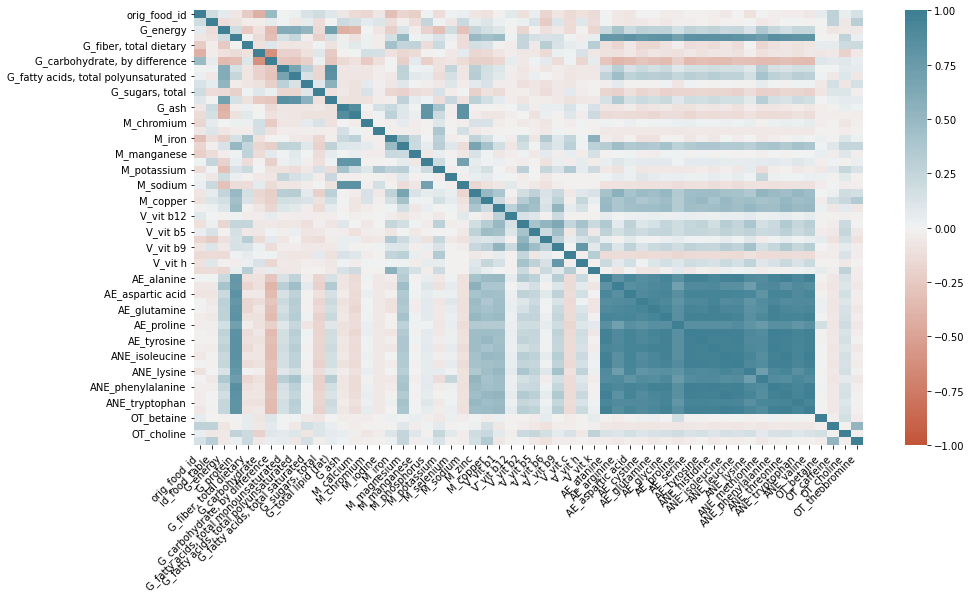

In [127]:
%matplotlib inline
corr = df.corr()
# corr.style.background_gradient(cmap='inferno')

plt.figure(figsize=(15,8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment='right');